In [2]:
import os, sys, importlib, random; import xarray as xr; 
import pandas as pd; import matplotlib.pyplot as plt
import numpy as np; 
sys.path.append('/Users/Ashton/Downloads/Research 2022/modview/');
import loader, viztools
img_dir = 'Users/Ashton/Downloads/Research 2022/AQDP/proc_figs/'

The procedure here is very straightforward (because the codebase in load_aqdp.py is strong!). Begin by importing module and loading raw aqdp data (profiles taken at 1 Hz).

In [3]:
import load_aqdp
importlib.reload(load_aqdp)
raw_dat = load_aqdp.build_raw()

Now let's separate all that data into chunks (ensembles) that last for 30 seconds each. Then, we will set up instances of the Veron and Wiles classes using those ensembles. Likewise, we create an instance of the class vehicle_motion that will have direct access to the formatted data. 

In [4]:
importlib.reload(load_aqdp); # reloading helps me update module in case I'm actively changing code
dt_seconds = 30;
ens = load_aqdp.Ensembles(dt_seconds, raw_dat); # separate into ensembles (chunks)
veron = load_aqdp.Veron(ens); # give turbulence methods access to data
wiles = load_aqdp.Wiles(ens); 
motion = load_aqdp.vehicle_motion(ens)

Will process 6791 ensembles lasting 30 s each.
The fitting range for the structure function method is [0.0884 0.442 ] meters


Altogether, instances of (1) Ensemble, (2) Wiles, (3) Veron, and (4) vehicle_motion will let us (1) extract raw measurements from raw_dat, (2) compute turbulence using structure functions, (3) compute turbulence using wavenumber spectra, and (4) compute metrics that may explain errors and uncertainties in the measurements. The fact that (2,3,4) are created using (1) as input ensures that data is always presented in a standard format and our results will be more traceable (every result is attached to an "index" that helps us extract the original data used to compute it). 

To see how this all works, let's run some of the main methods in (1,2,3,4) for a given ensemble (identified by an index). Here we use the method plot_obs_theory(), which is defined in the class TurbMethod(ABC), which is the parent class for both the veron and wiles classes. In each case, this method follows the appropriate steps to compute statistics from observations, fit theoretical curves, and then plot the results. Take a look at the code for that function for further details. 

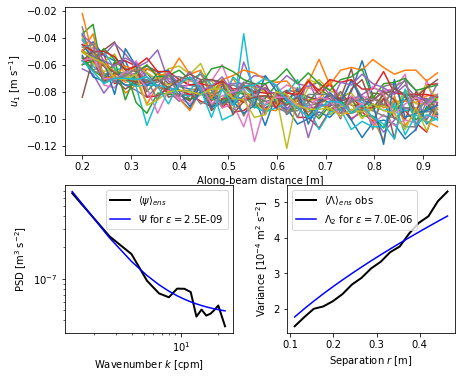

In [5]:
index = 236; # or whatever number we want
vels = ens.see_member(index); # extract velocity measurements for that index
# ---- prepare to plot
fig_dict = {'figsize':[7,6],'widths':[1,0.05,1],'heights':[1,1],
           'panels':([0,slice(0,3)],[1,0],[1,2])}
fig = viztools.panel_plot(fig_dict); fig.draw(); # take in figure settings and create visualization
fig.axes[0].plot( vels.length, vels.transpose() ) ; # plot velocity data
fig.axes[0].set_ylabel(r'$u_1$ [m s$^{-1}$]'); fig.axes[0].set_xlabel('Along-beam distance [m]')
# ---- turbulence estimates using the veron and wiles classes
veron.plot_obs_theory( fig.axes[1], index ) # calc obs_curve, fit theory_curve, and plot both.
fig.axes[1].legend()
wiles.plot_obs_theory( fig.axes[2], index )
fig.axes[2].legend()

This is all very nice (I hope), but it won't get us far when it comes to analyzing the data. We need results for more than one single index, and we need to save our results in a way that allows comparison. This is all done in the make_table function within aqdp_errors.py. In summary, make_table takes an instance of a turbulence method class (veron or wiles) and a list of indices. It returns a pandas dataframe including columns for a number of parameters that are useful to our analyses. 

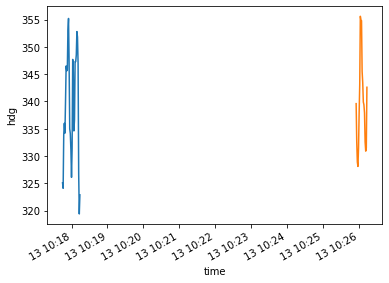

In [30]:
#motion.find_member( motion.data['roll'], 103).plot()
#raw_dat['roll'].sel(time=\
           #          slice('2015-01-13','2015-01-14').plot()
ens.pressure[103]
#ens.pressure[300]

#print(motion.find_member( motion.data['roll'], 103).var())

#print(motion.find_member( motion.data['roll'], 300).var())

variable = 'hdg'  #heading
motion.find_member( motion.data[variable*np.pi/180], 300).plot()


motion.find_member( motion.data[variable*np.pi/180], 302).plot()

In [38]:
importlib.reload( load_aqdp )

motion = load_aqdp.vehicle_motion( ens )

motion.shaking( 300 )

NameError: name 'variance' is not defined

In [50]:
importlib.reload( load_aqdp )
importlib.reload( aqdp_errors )
indices = np.arange( 0, 1000, 20)
table = aqdp_errors.make_table( wiles, indices )

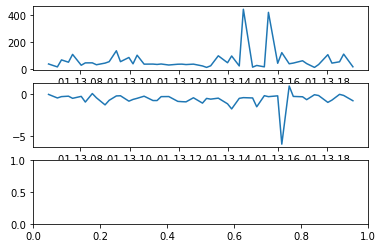

In [53]:
fog, ax = plt.subplots( 3 )

ax[0].plot( table['time'], table['pitch_var'] )
ax[1].plot( table['time'], np.log10(table['epsilon']) + 5 )

In [35]:
import aqdp_errors
#import warnings
import importlib
#warnings.filterwarnings('error')
importlib.reload(aqdp_errors)

indices = [random.randrange(0,3000) for kk in range(150)]; 
# will want to do a non-random sample at some point
indices = np.sort(indices) # increasing order
veron_table = aqdp_errors.make_table( veron, indices )
wiles_table = aqdp_errors.make_table( wiles, indices ) # these two lines will output pandas dataframes


# Homework for Ashton: figure out how to take these dataframes and save them into a file so that we 
# don't have to run the estimates again and again.

KeyboardInterrupt: 

In [83]:
# save dataframes as a csv
veron_table.to_csv('veron_table.csv');
wiles_table.to_csv('wiles_table.csv');

Text(0, 0.5, 'log(epsilon) - Veron')

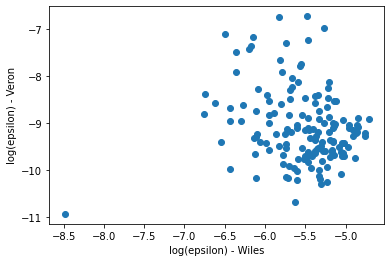

In [84]:
# Let's do a simple comparison of one method against the other. 
plt.scatter( np.log10(wiles_table['epsilon']), 
                      np.log10(veron_table['epsilon']))
#plt.scatter( vert_vel, ), label='Wiles method' )
plt.xlabel('log(epsilon) - Wiles')
plt.ylabel('log(epsilon) - Veron')

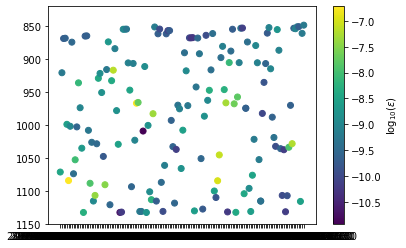

In [85]:
# Now another visualization: a time-depth section 
# this makes more sense when we compute for a one-by-one list of indices,
# rather than a random sample
plt.scatter( veron_table['time'], veron_table['depth'], 
            c = np.log10( veron_table['epsilon'] ) )
plt.ylim([1150, 820]); plt.colorbar(label=r'$\log_{10} (\varepsilon)$')

In [86]:
# Homework for Ashton: (1) make a histogram of vertical velocity
# (2) use what you learn from that to "group" the rows of tables according to 
# their vertical velocity. Then, draw histograms of log(epsilon) for each of those groups 
# draw them on top of each other so we can clearly see their differences.

,Unnamed: 0,Unnamed: 0.1,epsilon,noise,vert_vel,depth,time
0,0,16,3.491524e-09,5.636297e-08,0.259968,1071.443871,2015-01-13 07:02:00
1,1,37,5.898829e-10,1.630668e-07,0.253033,920.737300,2015-01-13 07:12:30
2,2,45,2.016326e-10,8.139252e-09,0.018567,868.776633,2015-01-13 07:16:30
3,3,52,2.437798e-10,7.378538e-09,-0.021548,868.355903,2015-01-13 07:27:00
4,4,69,2.687574e-09,6.248641e-08,-0.289387,999.028484,2015-01-13 07:35:30
...,...,...,...,...,...,...,...
145,145,2819,7.334830e-10,7.657269e-08,0.003069,851.023345,2015-01-14 18:15:30
146,146,2822,2.029123e-10,3.040369e-08,0.006167,850.810833,2015-01-14 18:26:00
147,147,2851,3.024256e-09,2.530490e-08,-0.350233,1116.038100,2015-01-14 18:40:30
148,148,2903,6.391516e-10,4.199131e-08,-0.378448,860.977345,2015-01-14 19:28:30


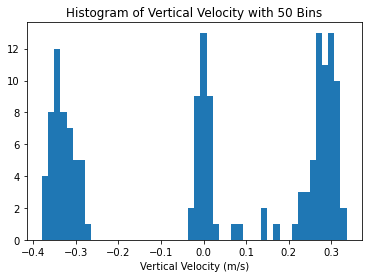

In [6]:
#(1:Histogram)

veron_table = pd.read_csv('veron_table.csv')

velocity = veron_table['vert_vel']

plt.hist(velocity,bins=50)
plt.title("Histogram of Vertical Velocity with 50 Bins")
plt.xlabel("Vertical Velocity (m/s)")
#plt.scatter( veron_table['vert_vel'], veron_table['depth'] )


veron_table

In [1]:
# (2: group rows of tables accroding to their vertical velocities) 
import pandas as pd

import matplotlib.pyplot as plt

veron_t = pd.read_csv('veron_table.csv');
wiles_t = pd.read_csv('wiles_table.csv');

vt = veron_t.sort_values('vert_vel');
wt = wiles_t.sort_values('vert_vel');


plt.figure(figsize=(5,4))
plt.hist( np.log10(vt['epsilon']), bins = 50, alpha=0.5, label="veron log(epsilon)");
plt.hist( np.log10(wt['epsilon']), bins = 50, alpha=0.5, label="wiles log(epsilon)");
plt.title('Histogram of log(Epsilon) sorted by vertical velocity')
plt.legend(loc='upper left')
plt.savefig('Histogram_epsilon_sorted_by_vert_vel.png')
plt.xlabel('log(epsilon)  (^-10)')


ImportError: cannot import name 'plt' from 'matplotlib' (C:\Users\Ashton\anaconda3\lib\site-packages\matplotlib\__init__.py)

In case you're wondering... how are we finding the optimal values of epsilon and the spectral noise floor? 
Both the wiles and veron classes have methods called cost_function(). These are measures that compare a theoretical curve to the observations available, and the goal is to find parameters for the theoretical curve that will minimize this cost function. The method estimate_epsilon, which belongs to TurbMethod(ABC) and is accessed by both the Wiles and Veron classes takes care of this: it uses an algorithm called "differential_evolution" that works some black magic and finds the optimal parameters. I say "black magic" because I don't really know how it works, but we can test whether or not it works. That's exactly what we'll do below:

In [ ]:
# Plot the cost function for a given index at many different values of epsilon and spectral noise floor
index = 440;
observ = veron.observations_curve(index); # get observational spectra
degfred = observ.shape[0];
observ = np.mean(observ,axis=0); # compute ensemble average
eps_trial = 10**(np.arange(-10,-6,0.1)) # all values of epsilon we will try
floor_trial = 10**(np.arange(-8,-6,0.04)); # all values of noise floor we will try
cost = np.zeros( (len(eps_trial), len(floor_trial)) ) # empty array to save our results
for kk in range(len(eps_trial)):
    for jj in range(len(floor_trial)):
        parameters = [eps_trial[kk], floor_trial[jj]]; # combination of parameters to use
        # for each combo, compute theoretical curve and compare to observations (cost function)
        cost[kk,jj] = veron.cost_function(parameters, 
                            observ, degfred)
# --- now that we tried all those values... let's see what the optimization algorithm gives us:
solution = veron.estimate_epsilon( index ); 

# --- plot the cost function for all values used
img = plt.pcolormesh( np.log10(eps_trial), np.log10(floor_trial), 
               cost.transpose(), vmin=-250, vmax=-150)
# --- draw black circle in optimal solution according to differential_evolution
plt.scatter( np.log10(solution[0]), np.log10(solution[1]), color='black')
plt.xlabel('Epsilon'); plt.ylabel('Spectral floor')
plt.colorbar(img); plt.title('Is black dot in minimum of cost function?')